# Create Lund planes with uproot/pandas


Sources: <br> [The Lund Jet Plane](https://arxiv.org/pdf/1807.04758.pdf) <br> [Calculating the Primary Lund Jet Plane density](https://arxiv.org/abs/2007.06578) <br>

Studying the internal structure of jets columnated from hadronic decay of quarks and gluons has become a major area of research. Jets carry valuable information for many areas of research (Higgs, QCD, SM & BSM) are involved. 

A useful way to describe the observables of the jets comes in the form of Lund plane diagrams. 
Lund planes are 2D representations of the phase space of the radiation in jets. The Lund plane maps two degrees of freedom, the transverse momentum $k_t$ and the angle $\Delta_{12}$, for a single emission. The two variables correspond to the x- and y-axis like: $\ln (R/\Delta_{12})$ and $\ln (k_t)$ respectively respectively. The third degree of freedom for the emission is??? 
The average density is important as well, however, have not had time to look at this.

To build a Lund plane, we need jet data that has been reclustered using the Cambridge-Aachen algorithm (see SoftDrop below), such that they are ordered to angle size between prongs.

Now creating the Lund plane, for a fully re-clustered (with C/A) jet $j$:

1. Decluster $j$'s last step into $j_1$ and $j_2$, where $j_1$ is of the harder branch such that $p_{t1} > p_{t2}$.

2. Determine the following variables:
$$ \Delta ≡ \Delta_{12} = \sqrt{(y_1 −y_2)^2 +(\phi_1 − \phi_2)^2 }$$
$$ k_t ≡ p_{t2} \cdot \Delta_{12}$$
$$ z ≡ \frac{ p_{t2} }{ p_{t1} + p_{t2} } $$ 
Where y is the pseudorapidity and phi is the azimuthal angle of the particle (these will be produced by SoftDrop).

3. Reiterate with $j$ = $j_1$, following the harder branch.

Interpretation: We follow the leading branch of a reclustered jet, until there are no more splittings. From this leading branch we calculate the required variables. The results of these calculations are then used as coordinates in a 2D histogram which, after going through all the jets, then forms the 2D Lund plane.
Question: Should you do this per jet or for all jets? 

Execution: Recursive SoftDrop creates the leading branch from my modeled data (by Pythia). At each step we have recorded: dr12 ($= \Delta_{12}$), jetpt ($= p_{t1}$) and z. To obtain $kt$ we use:
$$ k_t = z \cdot (p_{t1} + p_{t2}) * \Delta_{12}$$
$$ k_t = z \cdot (p_{t,parent}) * \Delta_{12}$$

## SoftDrop
Softdrop is what is used as a reclustering algorithm. I have data with both regular SoftDrop reclustering as well as recursive SoftDrop reclustering. Additionally, the reclustering is performed using the default Cambridge Aachen algorithm, as well as the KT algorithm. I will only show the KT algorithm results in one part because C/A is the standard reclustering algorithm and will most likely be more suitable for analysis. 

The dataset I use will be reclustered with an area $R = 0.4$ 

Then soft drop filters out wide-angle soft radiation following the
Soft Drop Condition: $$ \frac{ min(p_{t1},p_{t2})} { p_{t1} + p_{t2} } > z_{cut} \big( \frac{\Delta_{12}}{ R_0}\big)^\beta  $$, if a jet prong is found that passes the condition, the declustering stops and that prong is considered the final soft-drop jet.
Here $z_{cut}$ controls the jet grooming, $R_0$ is the original area of the jet and $\Delta_{12}$ is as explained before, the angle between two prongs due to the rapidity and azimuthal angle with the beam.

Recursive Soft Drop then goes further and continues to create the whole leading-branch of a jet.


## List of modules

In [1]:
import ROOT
import uproot

import numpy as np
import scipy as sp
import pandas as pd
import awkward as ak

import matplotlib.pyplot as plt
from matplotlib import colors

Welcome to JupyROOT 6.24/06


# filename(s) to .root files of SoftDrop reclustered datsets

In [319]:
fileName = "samples/07-09-2021_58MB_Pt120_tune14_10k_SD/JetToyHIResultSoftDrop.root"
fileName2 = "samples/07-09-2021_58MB_Pt120_tune14_10k_SD/JetToyHIResultSoftDrop_zc01.root"
fileName3 = "samples/07-09-2021_58MB_Pt120_tune14_10k_SD/JetToyHIResultSoftDrop_zc04_b2.root"
fileName4 = "samples/07-09-2021_58MB_Pt120_tune14_10k_SD/JetToyHIResultSoftDrop_zc01_b-2.root"

## Use uproot to obtain your root tree

Uproot loads in the datafile and converts it to a 'awkward Array' datastructure.
Awkward arrays are really useful. They work similarly to numpy arrays, but -- unlike numpy -- with awkward arrays you are allowed to have variable length sequences.


In [320]:
file = uproot.open(fileName)
tree = file['jetTreeSig']
branches = tree.arrays()

tree2 = uproot.open(fileName2)['jetTreeSig']
branches2 = tree2.arrays()

tree3 = uproot.open(fileName3)['jetTreeSig']
branches3 = tree3.arrays()

## Flatten arrays

Now I flatten the arrays to the point where I obtain a 1D array for each variable, filled with all the leading branch splittings of the jets.
In this case, splitting information is lost. 

In [321]:
flat_dr = ak.flatten(ak.flatten(branches["sigJetRecur_dr12"]))
flat_pt = ak.flatten(ak.flatten(branches["sigJetRecur_jetpt"]))
flat_z = ak.flatten(ak.flatten(branches["sigJetRecur_z"]))
#flat_kt = (1-flat_z) * flat_pt * flat_dr
flat_kt = flat_z * flat_pt * flat_dr

print(*(pt for pt in ak.flatten(branches["sigJetRecur_jetpt"])[:10]),sep="\n")
print(*(z for z in ak.flatten(branches["sigJetRecur_z"])[:10]),sep="\n")

pt_set = ak.flatten(branches["sigJetRecur_jetpt"])[:10]
z_set = ak.flatten(branches["sigJetRecur_z"])[:10]

[166, 164, 163, 161, 156, 133, 125, 123]
[119, 113, 99.2, 95.9, 79.8, 73.4, 70.4]
[15.5, 14.3, 13.7, 7.57]
[128, 128, 122, 70.2, 65.1, 56.5, 31.8, 23.9]
[103, 97.8, 93, 84.8, 79.8, 40.6, 39.6, 37.9]
[48.1, 47.5, 45.1, 42.2, 38.6]
[15.6, 13.2, 9.22, 5.46, 4.7]
[127, 66.3, 62.6, 62.4, 44.4, 34.1, 24.3, 12.8]
[84.7, 82.4, 79.9, 75, 60.5, 38.6, 29.5, 21.8]
[57.2, 55.7, 49.9, 47.7, 47.3, 44.6, 42, 26.3]
[0.0137, 0.00492, 0.0153, 0.0297, 0.151, 0.0541, 0.0209, 0.383]
[0.0461, 0.129, 0.034, 0.169, 0.0794, 0.0417, 0.415]
[0.081, 0.0435, 0.446, 0.423]
[0.00131, 0.0466, 0.427, 0.0735, 0.132, 0.438, 0.248, 0.447]
[0.0513, 0.0501, 0.0881, 0.0596, 0.492, 0.0243, 0.0442, 0.116]
[0.0131, 0.0517, 0.0634, 0.0856, 0.102]
[0.166, 0.302, 0.41, 0.139, 0.188]
[0.479, 0.0565, 0.00366, 0.289, 0.23, 0.288, 0.474, 0.379]
[0.0287, 0.0298, 0.0623, 0.193, 0.362, 0.235, 0.261, 0.416]
[0.0274, 0.107, 0.043, 0.00948, 0.0569, 0.0571, 0.376, 0.418]


## Plot Lund plane

Now I plot the Lund plane accordingly.

In [9]:
def Lund_Plot(kts, rs, R=0.4, norm=False, aspect=0.75):
    scatter_2dhist(np.log(R/rs), np.log(kts), r'$\ln (R/\Delta R)$', r'$\ln (k_t)$', norm, aspect)
    return

def scatter_2dhist(arr1, arr2, xlab, ylab, norm=False, aspect=25):
    fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize = (12, 5))#, gridspec_kw={'width_ratios': [1, 1.5]})
    fig.patch.set_facecolor('white')
    ax[0].plot(arr1, arr2, 'o', alpha=0.8, markersize=2)
    ax[0].set_xlabel(xlab)
    ax[0].set_ylabel(ylab)

    try:
        H, xedges, yedges = np.histogram2d(arr1, arr2, bins=20)
    except ValueError:
        H, xedges, yedges = np.histogram2d(arr1, arr2, range=[[0, 5], [-2, 4]], bins=20)
    if (norm):
        im = ax[1].imshow(H.T, interpolation='nearest', origin='lower', norm=colors.LogNorm(), extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect=aspect)
    else:
        im = ax[1].imshow(H.T, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect=aspect)
    fig.colorbar(im, ax=ax[1])
    ax[1].set_xlabel(xlab)
    ax[1].set_ylabel(ylab)
    plt.tight_layout()
    plt.show()
    return

## First look at Recursive SoftDrop normally

This is the Lund plane of the recursive softdrop data (zcut = 0, beta = 0) from Pythia events of pthat 120GeV and tune 14 of 10k events.

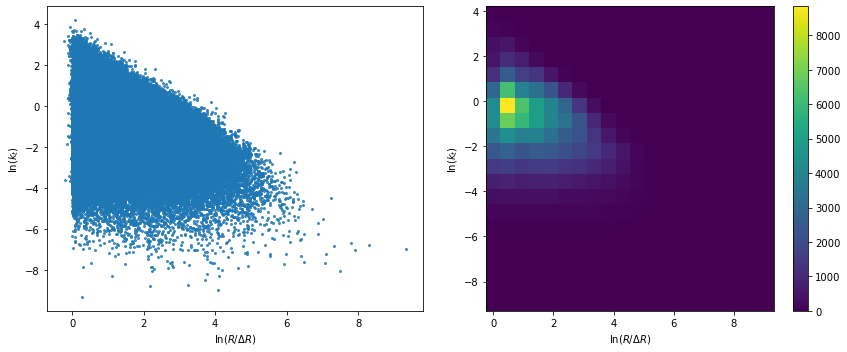

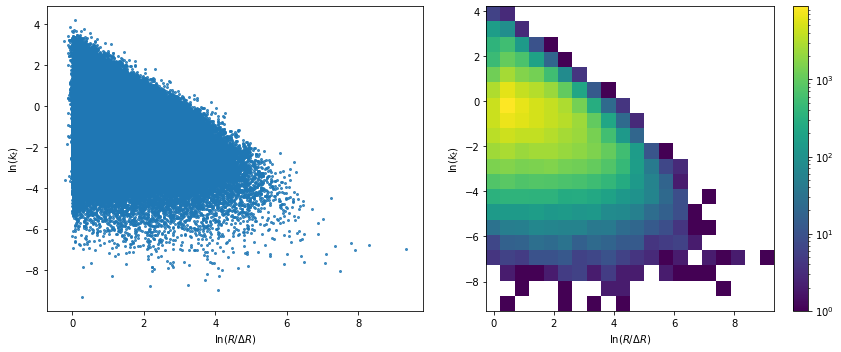

In [323]:
Lund_Plot(flat_kt, flat_dr)
Lund_Plot(flat_kt, flat_dr, norm=True)

## Cut at 130 GeV

Place a cut at 130 GeV to only obtain the hard scatterings

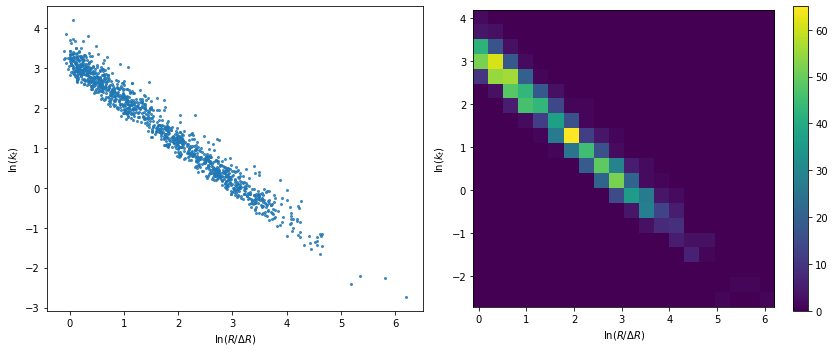

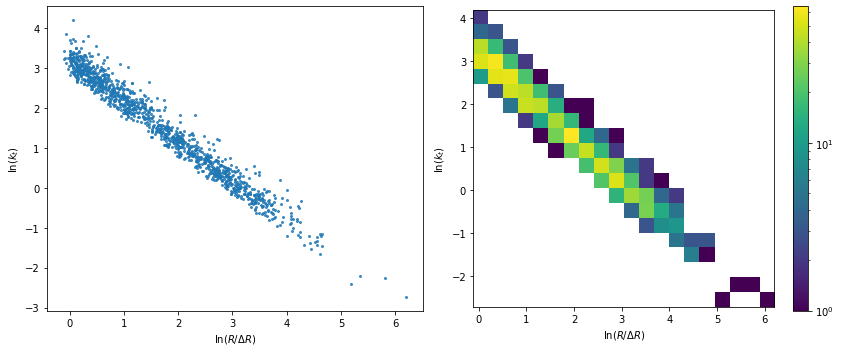

In [23]:
def cut_kt_dr(drs, pts, zs, pt_max=130):
    cut_pt = pts[pts >= pt_max]
    cut_z = zs[pts >= pt_max]
    cut_dr = drs[pts >= pt_max]
    cut_kts = cut_z * cut_pt * cut_dr
    return cut_kts, cut_dr

def cut_by_pt(arr, pts, pt_max=130):
    arr = arr[pts >= pt_max]
    return arr

Lund_Plot(*cut_kt_dr(flat_dr, flat_pt, flat_z), aspect=0.6)
Lund_Plot(*cut_kt_dr(flat_dr, flat_pt, flat_z), aspect=0.6,norm=True)

## Look at regular SoftDrop with zcut = 0.1

This Lund plane is made from regular SoftDrop being applied to the dataset

/Users/wesselrijk/.conda/envs/root_env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:207: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(


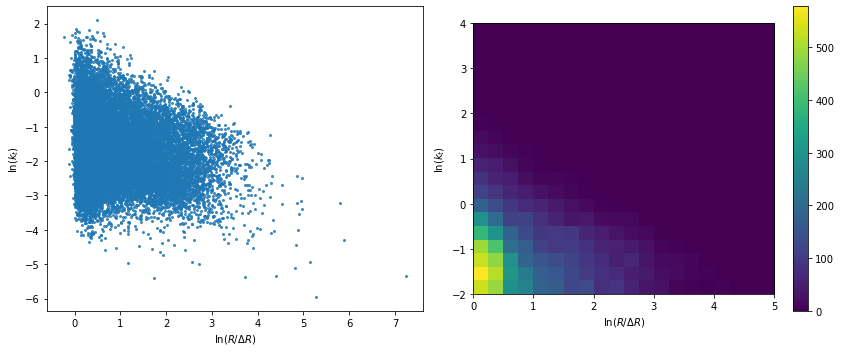

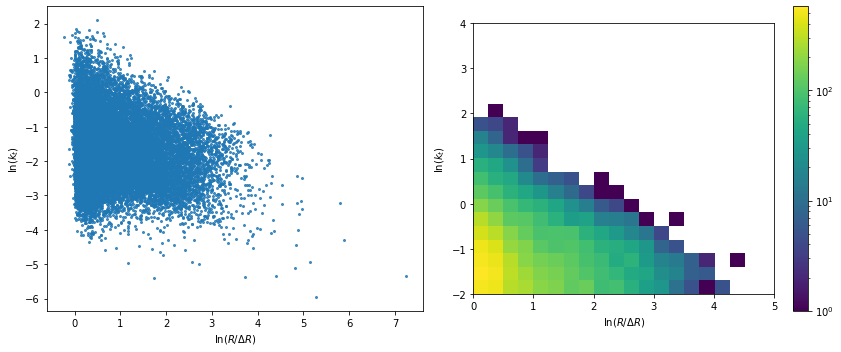

In [325]:
flat_dr_sd = ak.flatten(branches["sigJetSDZ01B00dr12"])
flat_pt_sd = ak.flatten(branches["sigJetSDZ01B00leadingtrack_pt"])
flat_z_sd = ak.flatten(branches["sigJetSDZ01B00zg"])
flat_kt_sd = flat_z_sd * flat_pt_sd * flat_dr_sd

Lund_Plot(flat_kt_sd, flat_dr_sd)
Lund_Plot(flat_kt_sd, flat_dr_sd, norm=True)

## And now see if anything changes if we take the KT reclustering algorithm

## And now try it with extra zcuts and betas

The cuts that have been applied are: <br>
SoftDrop zcut = 0.1 & beta = 0.0 <br>
Recursive SoftDrop zcut = 0.1 & beta = 0.0

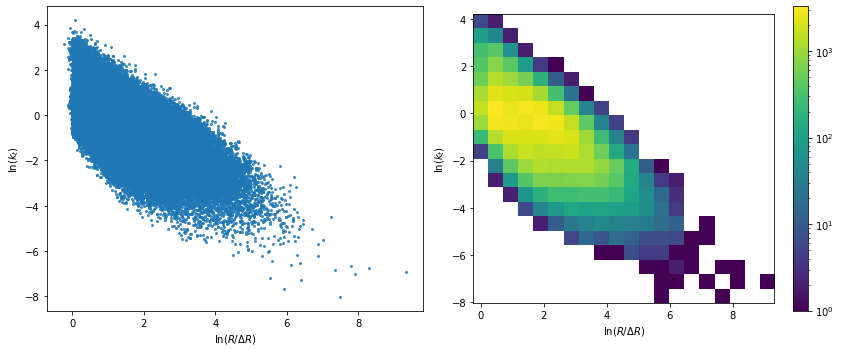

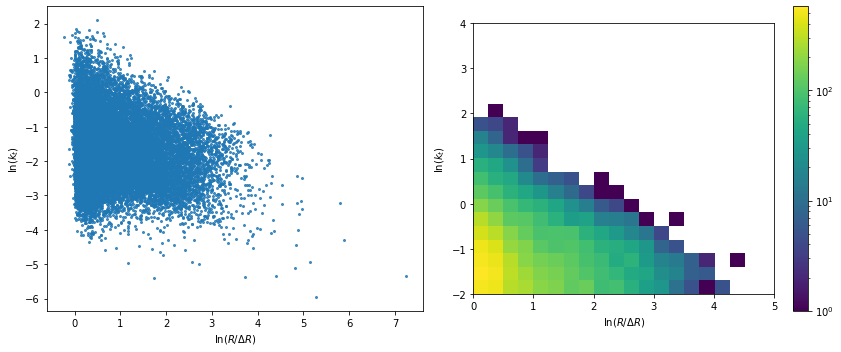

In [328]:
# Recursive Softdrop
flat_dr2 = ak.flatten(ak.flatten(branches2["sigJetRecur_dr12"]))
flat_pt2 = ak.flatten(ak.flatten(branches2["sigJetRecur_jetpt"]))
flat_z2 = ak.flatten(ak.flatten(branches2["sigJetRecur_z"]))
flat_kt2 = flat_z2 * flat_pt2 * flat_dr2

Lund_Plot(flat_kt2, flat_dr2, norm=True, aspect=0.75)

# SoftDrop
flat_dr_sd2 = ak.flatten(branches2["sigJetSDZ01B00dr12"])
flat_pt_sd2 = ak.flatten(branches2["sigJetSDZ01B00leadingtrack_pt"])
flat_z_sd2 = ak.flatten(branches2["sigJetSDZ01B00zg"])
flat_kt_sd2 = flat_z_sd2 * flat_pt_sd2 * flat_dr_sd2


Lund_Plot(flat_kt_sd2, flat_dr_sd2, norm=True)

## Some comparisons between SoftDrop Lund planes

Here I will compare the Lund Plane of the previous SoftDrop result with zcut = 0.1, the result with zcut = 0.1 and beta = 0.3 and a 

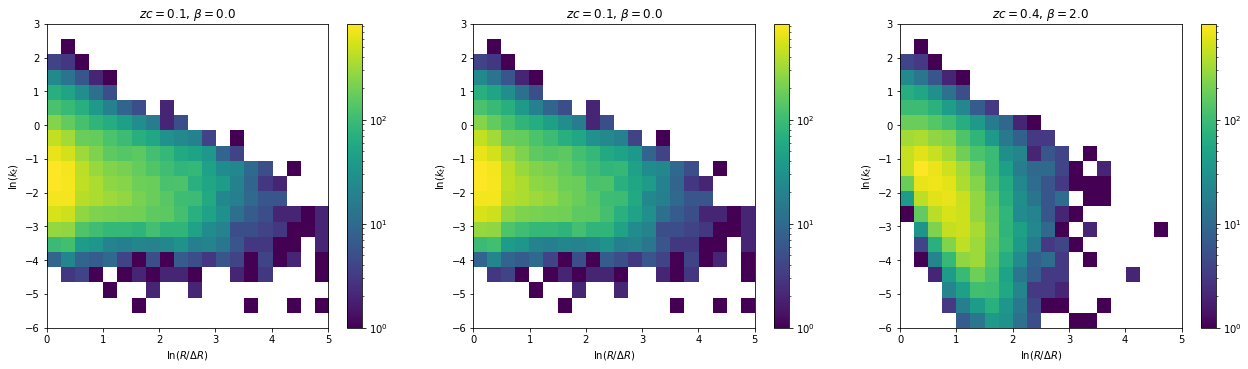

In [329]:
fig, ax = plt.subplots(1, 3, sharex=False, sharey=False, figsize = (18, 5))#, gridspec_kw={'width_ratios': [1, 1.5]})
fig.patch.set_facecolor('white')

# First dataset zcut = 0.1
H, xedges, yedges = np.histogram2d(np.log(0.4/flat_dr_sd), np.log(flat_kt_sd), range=[[0, 5], [-6, 3]], bins=20)
im = ax[0].imshow(H.T, interpolation='nearest', origin='lower', norm=colors.LogNorm(), extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect=0.6)
ax[0].title.set_text(r'$zc = 0.1$, $\beta = 0.0$')

# Second dataset zcut = 0.4, beta = 2.0
H2, xedges2, yedges2 = np.histogram2d(np.log(0.4/flat_dr_sd2), np.log(flat_kt_sd2), range=[[0, 5], [-6, 3]], bins=20)
im2 = ax[1].imshow(H2.T, interpolation='nearest', origin='lower', norm=colors.LogNorm(), extent=[xedges2[0], xedges2[-1], yedges2[0], yedges2[-1]], aspect=0.6)
ax[1].title.set_text(r'$zc = 0.1$, $\beta = 0.0$')

# Third dataset zcut = 0.1, beta = -2.0
flat_dr_sd3 = ak.flatten(branches3["sigJetSDZ01B00dr12"])
flat_pt_sd3 = ak.flatten(branches3["sigJetSDZ01B00leadingtrack_pt"])
flat_z_sd3 = ak.flatten(branches3["sigJetSDZ01B00zg"])
flat_kt_sd3 = flat_z_sd3 * flat_pt_sd3 * flat_dr_sd3
H3, xedges3, yedges3 = np.histogram2d(np.log(0.4/flat_dr_sd3), np.log(flat_kt_sd3), range=[[0, 5], [-6, 3]], bins=20)
im2 = ax[2].imshow(H3.T, interpolation='nearest', origin='lower', norm=colors.LogNorm(), extent=[xedges3[0], xedges3[-1], yedges3[0], yedges3[-1]], aspect=0.6)
ax[2].title.set_text(r'$zc = 0.4$, $\beta = 2.0$')

for a in ax:
    fig.colorbar(im, ax=a)
    a.set_xlabel(r'$\ln (R/\Delta R)$')
    a.set_ylabel(r'$\ln (k_t)$')
plt.tight_layout()
plt.show()

## Comparison between Recursive SoftDrop Planes

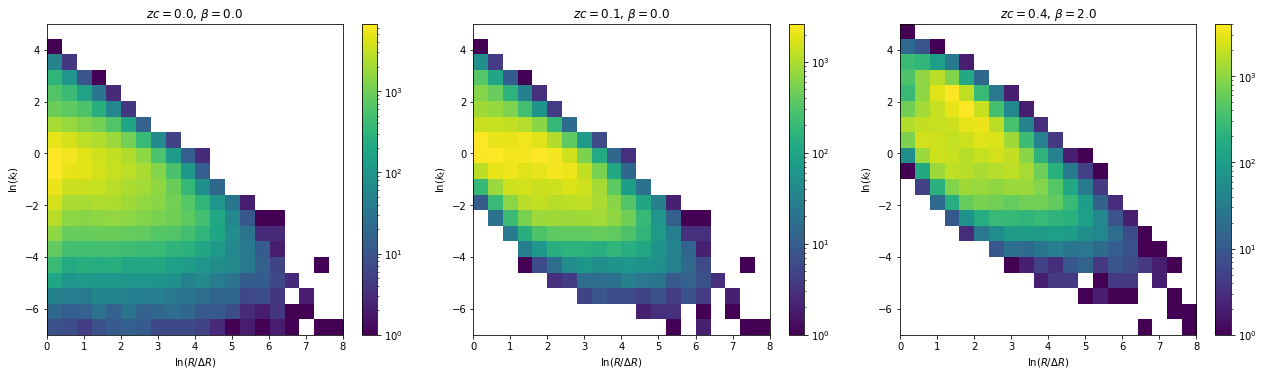

In [330]:
fig, ax = plt.subplots(1, 3, sharex=False, sharey=False, figsize = (18, 5))#, gridspec_kw={'width_ratios': [1, 1.5]})
fig.patch.set_facecolor('white')

# First dataset zcut = 0.0
H, xedges, yedges = np.histogram2d(np.log(0.4/flat_dr), np.log(flat_kt), range=[[0, 8], [-7, 5]], bins=20)
im = ax[0].imshow(H.T, interpolation='nearest', origin='lower', norm=colors.LogNorm(), extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect=0.7)
ax[0].title.set_text(r'$zc = 0.0$, $\beta = 0.0$')

# Second dataset zcut = 0.4, beta = 2.0
H2, xedges2, yedges2 = np.histogram2d(np.log(0.4/flat_dr2), np.log(flat_kt2), range=[[0, 8], [-7, 5]], bins=20)
im2 = ax[1].imshow(H2.T, interpolation='nearest', origin='lower', norm=colors.LogNorm(), extent=[xedges2[0], xedges2[-1], yedges2[0], yedges2[-1]], aspect=0.7)
ax[1].title.set_text(r'$zc = 0.1$, $\beta = 0.0$')

# Third dataset zcut = 0.1, beta = -2.0
flat_dr3 = ak.flatten(ak.flatten(branches3["sigJetRecur_dr12"]))
flat_pt3 = ak.flatten(ak.flatten(branches3["sigJetRecur_jetpt"]))
flat_z3 = ak.flatten(ak.flatten(branches3["sigJetRecur_z"]))
flat_kt3 = (1-flat_z3) * flat_pt3 * flat_dr3
H3, xedges3, yedges3 = np.histogram2d(np.log(0.4/flat_dr3), np.log(flat_kt3), range=[[0, 8], [-7, 5]], bins=20)
im3 = ax[2].imshow(H3.T, interpolation='nearest', origin='lower', norm=colors.LogNorm(), extent=[xedges3[0], xedges3[-1], yedges3[0], yedges3[-1]], aspect=0.7)
ax[2].title.set_text(r'$zc = 0.4$, $\beta = 2.0$')

imgs = [im, im2, im3]

for i, a in enumerate(ax):
    fig.colorbar(imgs[i], ax=a)
    a.set_xlabel(r'$\ln (R/\Delta R)$')
    a.set_ylabel(r'$\ln (k_t)$')
plt.tight_layout()
plt.show()

## Comparison of Recursive Soft Drop planes with pt cut at 130 GeV

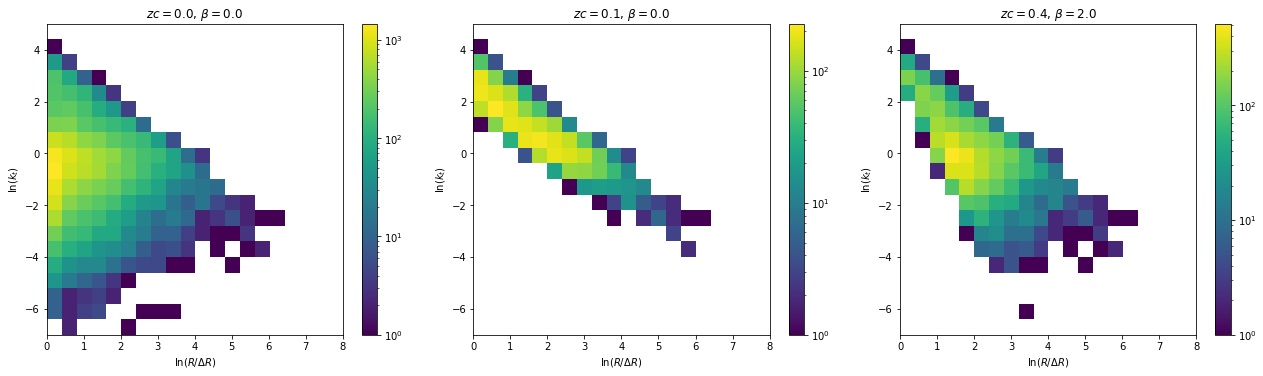

In [331]:
fig, ax = plt.subplots(1, 3, sharex=False, sharey=False, figsize = (18, 5))#, gridspec_kw={'width_ratios': [1, 1.5]})
fig.patch.set_facecolor('white')

# First dataset zcut = 0.0
cut_kt, cut_dr = cut_kt_dr(flat_dr, flat_pt, flat_z)
H, xedges, yedges = np.histogram2d(np.log(0.4/cut_dr), np.log(cut_kt), range=[[0, 8], [-7, 5]], bins=20)
im = ax[0].imshow(H.T, interpolation='nearest', origin='lower', norm=colors.LogNorm(), extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect=0.7)
ax[0].title.set_text(r'$zc = 0.0$, $\beta = 0.0$')

# Second dataset zcut = 0.4, beta = 2.0
cut_kt2, cut_dr2 = cut_kt_dr(flat_dr2, flat_pt2, flat_z2)
H2, xedges, yedges = np.histogram2d(np.log(0.4/cut_dr2), np.log(cut_kt2), range=[[0, 8], [-7, 5]], bins=20)
im2 = ax[1].imshow(H2.T, interpolation='nearest', origin='lower', norm=colors.LogNorm(), extent=[xedges2[0], xedges2[-1], yedges2[0], yedges2[-1]], aspect=0.7)
ax[1].title.set_text(r'$zc = 0.1$, $\beta = 0.0$')

# Third dataset zcut = 0.1, beta = -2.0
cut_kt3, cut_dr3 = cut_kt_dr(flat_dr3, flat_pt3, flat_z3)
H3, xedges, yedges = np.histogram2d(np.log(0.4/cut_dr3), np.log(cut_kt3), range=[[0, 8], [-7, 5]], bins=20)
im3 = ax[2].imshow(H3.T, interpolation='nearest', origin='lower', norm=colors.LogNorm(), extent=[xedges3[0], xedges3[-1], yedges3[0], yedges3[-1]], aspect=0.7)
ax[2].title.set_text(r'$zc = 0.4$, $\beta = 2.0$')

imgs = [im, im2, im3]

for i, a in enumerate(ax):
    fig.colorbar(imgs[i], ax=a)
    a.set_xlabel(r'$\ln (R/\Delta R)$')
    a.set_ylabel(r'$\ln (k_t)$')
plt.tight_layout()
plt.show()

## General function for comparing Lund planes

In [12]:
def compare_lunds(files, titles, range= [[0, 8], [-7, 5]], bins=20,aspect=0.7):
    fig, ax = plt.subplots(1, 3, sharex=False, sharey=False, figsize = (18, 5))
    fig.patch.set_facecolor('white')

    for i, fileName in enumerate(files):
        directory = 'samples/07-09-2021_58MB_Pt120_tune14_10k_SD/'
        branches = uproot.open(directory+fileName)['jetTreeSig'].arrays()
        
        flat_dr = ak.flatten(ak.flatten(branches["sigJetRecur_dr12"]))
        flat_pt = ak.flatten(ak.flatten(branches["sigJetRecur_jetpt"]))
        flat_z = ak.flatten(ak.flatten(branches["sigJetRecur_z"]))
        flat_kt = flat_z * flat_pt * flat_dr
        cut_kt, cut_dr = cut_kt_dr(flat_dr, flat_pt, flat_z)
        H, xedges, yedges = np.histogram2d(np.log(0.4/cut_dr), np.log(cut_kt), range=range, bins=bins)
        im = ax[i].imshow(H.T, interpolation='nearest', origin='lower', norm=colors.LogNorm(), extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect=aspect)
        ax[i].title.set_text(titles[i])

        fig.colorbar(im, ax=ax[i])
        ax[i].set_xlabel(r'$\ln (R/\Delta R)$')
        ax[i].set_ylabel(r'$\ln (k_t)$')

    plt.tight_layout()
    plt.show()
    return

## Full comparison Zcut

Info:
- 10000 events
- pthat = 120 GeV
- tune 14
- R = 0.4

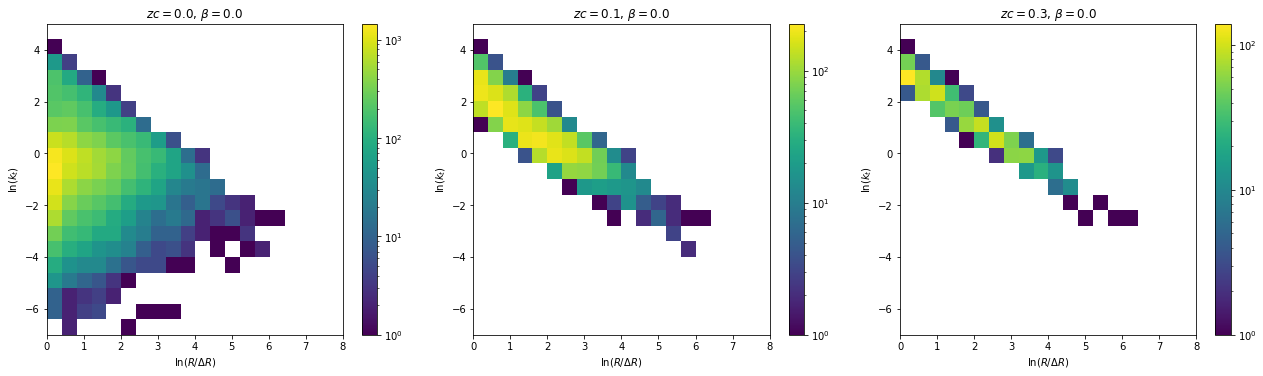

In [18]:
files_to_compare = ['JetToyHIResultSoftDrop.root', 'JetToyHIResultSoftDrop_zc01.root', 'JetToyHIResultSoftDrop_zc03.root']
titles = [r'$zc = 0.0$, $\beta = 0.0$', r'$zc = 0.1$, $\beta = 0.0$', r'$zc = 0.3$, $\beta = 0.0$']

compare_lunds(files_to_compare, titles)

## Full comparison +Beta

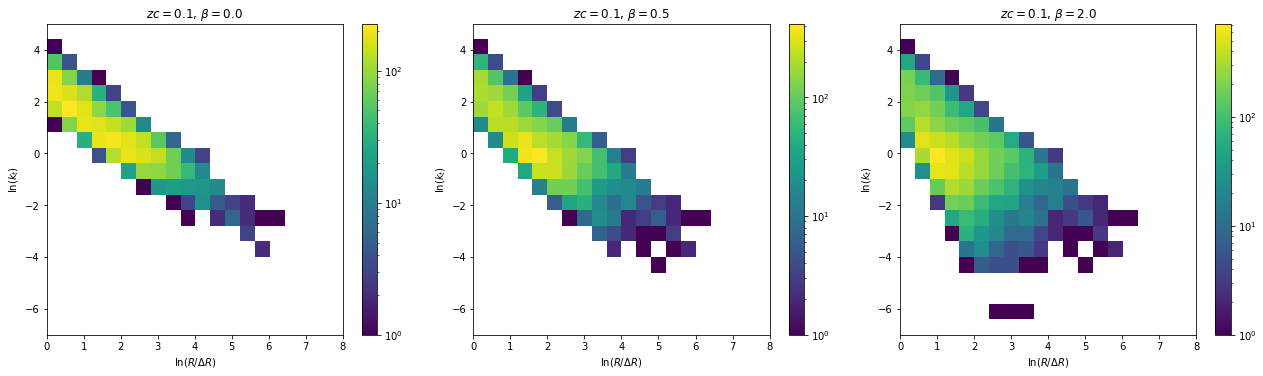

In [19]:
files_to_compare = ['JetToyHIResultSoftDrop_zc01.root', 'JetToyHIResultSoftDrop_zc01_b05.root', 'JetToyHIResultSoftDrop_zc01_b2.root']
titles = [r'$zc = 0.1$, $\beta = 0.0$', r'$zc = 0.1$, $\beta = 0.5$', r'$zc = 0.1$, $\beta = 2.0$']

compare_lunds(files_to_compare, titles)

## Full comparison -Beta

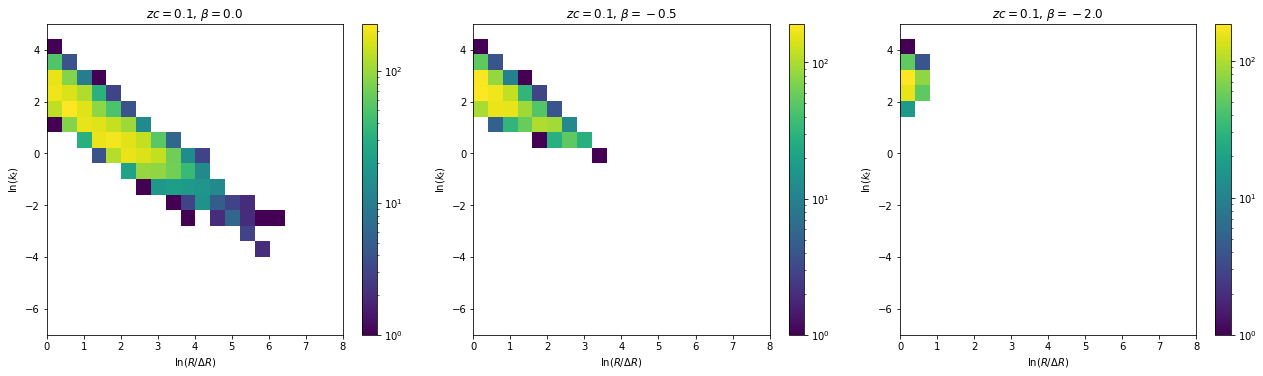

In [20]:
files_to_compare = ['JetToyHIResultSoftDrop_zc01.root', 'JetToyHIResultSoftDrop_zc01_b-05.root', 'JetToyHIResultSoftDrop_zc01_b-2.root']
titles = [r'$zc = 0.1$, $\beta = 0.0$', r'$zc = 0.1$, $\beta = -0.5$', r'$zc = 0.1$, $\beta = -2.0$']

compare_lunds(files_to_compare, titles)

Questions:
- What do these results tell us? 
    Beta plus 2: less dropped with increasing
    Beta of -2: 
- How can we use these results?

## Splittings versus $p_t$

Plot of the number of splittings versus pt.

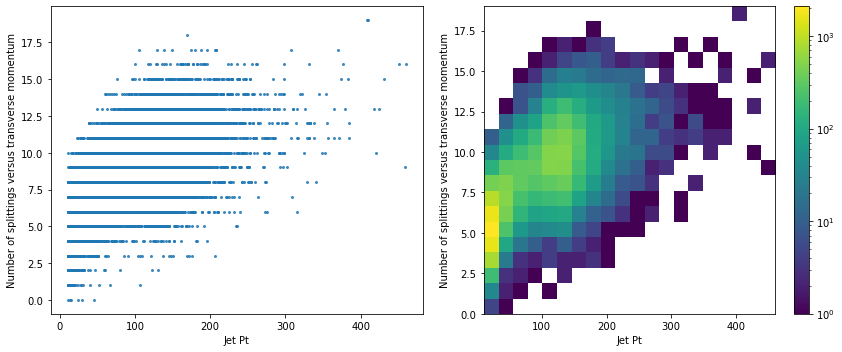

In [332]:
jet_pts = ak.flatten(branches['sigJetPt'])
nr_splits = ak.flatten(branches['sigJetRecur_nSD'])

scatter_2dhist(jet_pts, nr_splits, "Jet Pt", "Number of splittings", norm=True)